In [47]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

### Feature Engineering Conclusion
*Before there were 4 features, And now there are 19 features in total including-*
| Category           | Purpose             |
| ------------------ | ------------------- |
| Time features      | Seasonality         |
| Lag features       | Memory              |
| Rolling features   | Trend & volatility  |
| Aggregate features | Indicate-Behavior   |

In [18]:
df = pd.read_csv("../data/processed/featured_data.csv", parse_dates=["date"])

In [19]:
df.dtypes

date               datetime64[ns]
store                       int64
item                        int64
sales                       int64
year                        int64
month                       int64
week                        int64
day                         int64
dayofweek                   int64
is_weekend                  int64
sales_lag_1               float64
sales_lag_7               float64
sales_lag_14              float64
sales_lag_28              float64
rolling_mean_7            float64
rolling_mean_14           float64
rolling_mean_28           float64
store_avg_sales           float64
item_avg_sales            float64
dtype: object

In [20]:
df.head()

,date,store,item,sales,year,month,week,day,dayofweek,is_weekend,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,store_avg_sales,item_avg_sales
0,2013-01-29,1,1,6,2013,1,5,29,1,0,11.0,7.0,5.0,13.0,10.428571,10.642857,10.714286,47.268379,21.981599
1,2013-01-30,1,1,9,2013,1,5,30,2,0,6.0,9.0,7.0,11.0,10.285714,10.714286,10.464286,47.268379,21.981599
2,2013-01-31,1,1,13,2013,1,5,31,3,0,9.0,8.0,16.0,14.0,10.285714,10.857143,10.392857,47.268379,21.981599
3,2013-02-01,1,1,11,2013,2,5,1,4,0,13.0,14.0,7.0,13.0,11.000000,10.642857,10.357143,47.268379,21.981599
4,2013-02-02,1,1,21,2013,2,5,2,5,1,11.0,12.0,18.0,10.0,10.571429,10.928571,10.285714,47.268379,21.981599


## Data Split - Train & Validation

In [21]:
train_df = df[df["date"] < "2017-01-01"]
val_df   = df[df["date"] >= "2017-01-01"]

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716500 entries, 0 to 898634
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             716500 non-null  datetime64[ns]
 1   store            716500 non-null  int64         
 2   item             716500 non-null  int64         
 3   sales            716500 non-null  int64         
 4   year             716500 non-null  int64         
 5   month            716500 non-null  int64         
 6   week             716500 non-null  int64         
 7   day              716500 non-null  int64         
 8   dayofweek        716500 non-null  int64         
 9   is_weekend       716500 non-null  int64         
 10  sales_lag_1      716500 non-null  float64       
 11  sales_lag_7      716500 non-null  float64       
 12  sales_lag_14     716500 non-null  float64       
 13  sales_lag_28     716500 non-null  float64       
 14  rolling_mean_7   716500 n

In [23]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182500 entries, 1433 to 898999
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             182500 non-null  datetime64[ns]
 1   store            182500 non-null  int64         
 2   item             182500 non-null  int64         
 3   sales            182500 non-null  int64         
 4   year             182500 non-null  int64         
 5   month            182500 non-null  int64         
 6   week             182500 non-null  int64         
 7   day              182500 non-null  int64         
 8   dayofweek        182500 non-null  int64         
 9   is_weekend       182500 non-null  int64         
 10  sales_lag_1      182500 non-null  float64       
 11  sales_lag_7      182500 non-null  float64       
 12  sales_lag_14     182500 non-null  float64       
 13  sales_lag_28     182500 non-null  float64       
 14  rolling_mean_7   18250

In [24]:
train_df.tail()

,date,store,item,sales,year,month,week,day,dayofweek,is_weekend,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,store_avg_sales,item_avg_sales
898630,2016-12-27,10,50,60,2016,12,52,27,1,0,61.0,58.0,69.0,84.0,61.714286,61.571429,63.642857,58.709288,65.882202
898631,2016-12-28,10,50,43,2016,12,52,28,2,0,60.0,64.0,53.0,74.0,62.000000,60.928571,62.785714,58.709288,65.882202
898632,2016-12-29,10,50,68,2016,12,52,29,3,0,43.0,56.0,63.0,60.0,59.000000,60.214286,61.678571,58.709288,65.882202
898633,2016-12-30,10,50,63,2016,12,52,30,4,0,68.0,64.0,69.0,88.0,60.714286,60.571429,61.964286,58.709288,65.882202
898634,2016-12-31,10,50,64,2016,12,52,31,5,1,63.0,65.0,67.0,81.0,60.571429,60.142857,61.071429,58.709288,65.882202


In [25]:
val_df.head()

,date,store,item,sales,year,month,week,day,dayofweek,is_weekend,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,store_avg_sales,item_avg_sales
1433,2017-01-01,1,1,19,2017,1,52,1,6,1,14.0,20.0,22.0,24.0,17.285714,17.428571,16.178571,47.268379,21.981599
1434,2017-01-02,1,1,15,2017,1,1,2,0,0,19.0,16.0,17.0,13.0,17.142857,17.214286,16.000000,47.268379,21.981599
1435,2017-01-03,1,1,10,2017,1,1,3,1,0,15.0,10.0,18.0,10.0,17.000000,17.071429,16.071429,47.268379,21.981599
1436,2017-01-04,1,1,16,2017,1,1,4,2,0,10.0,16.0,12.0,17.0,17.000000,16.500000,16.071429,47.268379,21.981599
1437,2017-01-05,1,1,14,2017,1,1,5,3,0,16.0,21.0,20.0,15.0,17.000000,16.785714,16.035714,47.268379,21.981599


## XGBoost Implementation

### 1. Training 

In [26]:
TARGET = "sales"

DROP_COLS = ["date", "sales"]

FEATURES = [c for c in train_df.columns if c not in DROP_COLS]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]


In [27]:
FEATURES

['store',
 'item',
 'year',
 'month',
 'week',
 'day',
 'dayofweek',
 'is_weekend',
 'sales_lag_1',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_28',
 'rolling_mean_7',
 'rolling_mean_14',
 'rolling_mean_28',
 'store_avg_sales',
 'item_avg_sales']

In [28]:
## Training XGBoost model

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
val_preds = xgb_model.predict(X_val)
val_preds

array([19.526623, 13.029686, 15.177684, ..., 66.378296, 69.726875,
       73.09394 ], shape=(182500,), dtype=float32)

### 2. Evaluation on Validation data

In [35]:

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("RMSE:", rmse)


RMSE: 7.91263898151909


In [36]:
#Business Metric
mape = np.mean(np.abs((y_val - val_preds) / y_val)) * 100
print("MAPE:", mape)

MAPE: 12.436141004329388


### 2.1 Feature Importance

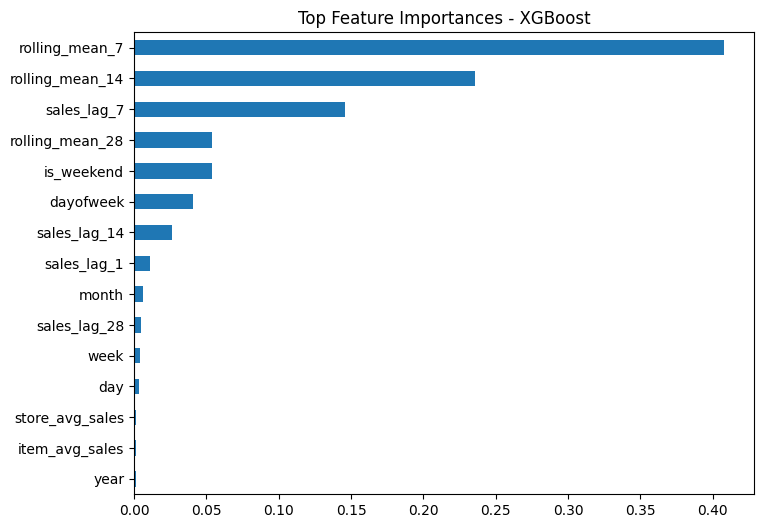

In [42]:

importance = pd.Series(
    xgb_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=True)

plt.figure(figsize=(8,6))
importance.tail(15).plot(kind="barh")
plt.title("Top Feature Importances - XGBoost")
plt.savefig("../plots/xgboost_plots/Xgboost_feature_imp_val_pred.png")
plt.show()

## 2.2 Interpretation

RMSE: 7.91
- On average our forecast is off by ~8 units of sales (reasonable)
- 
MAPE: 12.43%
| MAPE Range | Quality     |
| ---------- | ----------- |
| <10%       | Excellent   |
| **10–15%** | Very Good   |
| 15–20%     | Acceptable  |
| >20%       | Weak        |

Feature Importance
- Recent demand trends over the last 1–4 weeks are the strongest predictors of future sales.

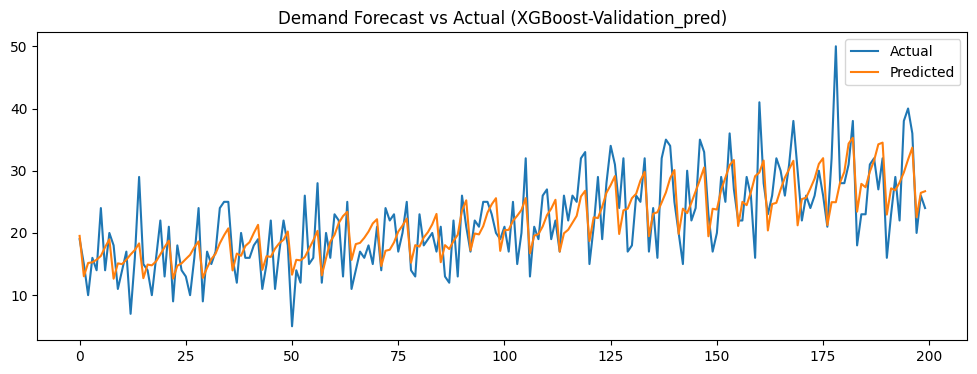

In [45]:
plt.figure(figsize=(12,4))
plt.plot(y_val.values[:200], label="Actual")
plt.plot(val_preds[:200], label="Predicted")
plt.legend()
plt.title("Demand Forecast vs Actual (XGBoost-Validation_pred)")
plt.savefig("../plots/xgboost_plots/Xgboost_demand_vs_val_pred.png")
plt.show()

### 3. Hyperparameters Tuning

In [49]:

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

param_grid = {
    "n_estimators": [300, 500, 800, 1000],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.3, 0.5]
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

print("Best params:", search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}


### 3.1 Evaluation on Tuned Model

In [50]:
val_preds_tuned = best_model.predict(X_val)

rmse_tuned = np.sqrt(mean_squared_error(y_val, val_preds_tuned))
mape_tuned = np.mean(np.abs((y_val - val_preds_tuned) / y_val)) * 100

print("Tuned RMSE:", rmse_tuned)
print("Tuned MAPE:", mape_tuned)

Tuned RMSE: 7.910297790014544
Tuned MAPE: 12.493514881236715


### 3.2 Interpretation (2)

Why Tuning Did not Help Much 

In structured demand data:

- Feature quality > hyperparameters
- When lag & rolling features are strong:
- XGBoost becomes very stable
- Gains from tuning are small (0–1%)

*Choosing the model that performs best on validation data — not the one that looks more complex.*

### 4. Final Model Training

In [53]:
final_X = pd.concat([X_train, X_val])
final_y = pd.concat([y_train, y_val])

final_model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(final_X, final_y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)